# Lab 5: Wide and Deep Neural Networks
### Vince Miller, Andrew Kozelsky, Michael Han, Ryan Cole

## Business Understanding


The dataset selected for lab 5 was wine review data collected by wine enthusiast magazine. The data was made available by a kaggle user who wanted a model that could predict the ‘points’ of a wine by using the description that a ‘taster’ gave. Our team could not justify this use of the dataset for this specific prediction task therefore we chose an alternative. The goal of our model is to use points, description, country, region, taster, variety and vineyard to predict the sale price of the wine. We suspect that a model utilizing information that is closely related to production and the quality of the wine could give wine producers a benchmark for comparing their raw products to the market.

While a lower MSE certainly means a better prediction algorithm we feel that in our case this number will be larger than what we would consider acceptable for predicting wine price because of the unknown variance we cannot capture within marketing. Our model is at the liberty of the highly variant wine price/quality relationship and we will seek to minimize it to the best of our ability, but the factors we are not utilizing such as marketing dollars spent, sale location (market, restaurant, etc. ), or novelty value will certainly affect the price. Wine manufacturers will still be interested in the model because they can hire a sommelier to give information necessary to predict a price with our model. With a predicted price as well as a known MSE a wine manufacture can start to consider how much or little the quality of their product typically sells for.


## Attribute Definitions

The data set consists of 9 variables and 77,267 observations. The response variable, price, is continuous.

The other **13** attributes are as follows: 
*****

- **country**: country of origin of the wine


- **description**: A few sentences that describe the flavors and general impressions of the wine. 


- **points**: The number of points awarded to the wine by the reviewer. According to the website from which it was scraped, only               wines that score above 80 are posted. 


- **price**: price of the wine per bottle


- **province**: The province/state within each country from where the wine originates.


- **region_1**: The specific wine growing area within the state/province


- **region_2**: In some cases, a more specific region is available. 


- **taster_name**: the sommelier conducting the review 


- **taster_twitter_handle**: the sommelier's twitter handle


- **title**: the title of the wine review 


- **variety**: the variety of grapes used to make the wine


- **vineyard**: the name of the vineyard where the wine was produced

Preparation (40 points total)
* [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
* [10 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 
* [10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
* [10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Read in Data
We read the data into a pandas dataframe and drop variables that we believe won't be useful in our analysis. The variable taster_twitter_handle is simply unique to each taster, and so it wouldn't be predictive at all. The title of the review also probably won't give us much information. Region 2 has many missing values relatively. We will drop this column. After dropping this column we will drop the remaining rows that contain missing values.  Our data without missing still values is a diverse mix of countries, varieties, tasters, and locales. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(r'.\winemag-data-130k-v2.csv',index_col=0)

#drop unnecessary variables
#We drop region_2 as it has many nans
df = df.drop(['taster_twitter_handle','title','designation'],axis=1)

df.head()

,country,description,points,price,province,region_1,region_2,taster_name,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Roger Voss,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks


In [2]:
# view the missing variables
df.apply(lambda x: sum(pd.isna(x)))

country           63
description        0
points             0
price           8996
province          63
region_1       21247
region_2       79460
taster_name    26244
variety            1
winery             0
dtype: int64

Region 2 has many missing values relatively. We attemped to combine region 1 and region 2 into 1 string value for each observation. This created too many unique values for the variable and we couldnt encode the categorical variables. Taking the easy way out we will drop region 2.

In [3]:
# drop region 2
df.drop(['region_2'],inplace=True,axis=1)

To save some of our observations we will impute unknown to the missing values in taster. This taster will be unknown. This we be useful if a wine company has a taster that was not in the dataset.

In [4]:
# fill na for taster 
df.loc[df.taster_name.isna(),'taster_name'] = 'Unknown'

In [5]:
df.dropna(axis=0,inplace=True)

As a data processing step our group removed the stop words from the description of each instance. Once the description feature in each instance was converted to a word list of strings. These lists will eventually be embedded in the deep branch.  

In [6]:
#function for preprocessing the description data
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

def preprocess(sentence):
	sentence = sentence.lower()
	tokenizer = RegexpTokenizer(r'\w+')
	tokens = tokenizer.tokenize(sentence)
	filtered_words = [w for w in tokens if not w in stopwords.words('english')]
	return " ".join(filtered_words)

#remove stop words and punctuation from description
df.loc[:,'description'] = df['description'].apply(preprocess)

In [7]:
df.to_csv('df.csv',header=True)

In [6]:
# read dataframe that already has the description processing complete
df = pd.read_csv(r'.\df.csv',index_col=0)

In [7]:
# view the dataframe read in 
df.reset_index(drop=True,inplace=True)
df.head()

,country,description,points,price,province,region_1,taster_name,variety,winery
0,US,tart snappy flavors lime flesh rind dominate g...,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm
1,US,pineapple rind lemon pith orange blossom start...,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian
2,US,much like regular bottling 2012 comes across r...,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks
3,Spain,blackberry raspberry aromas show typical navar...,87,15.0,Northern Spain,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem
4,Italy,bright informal red opens aromas candied berry...,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Frappato,Terre di Giurfo


Next, we choose what variables we will cross in our neural network. Taster name will be crossed with variety and country in attempt to memorize the price association for taster and the variety they are tasting or country they are tasting in. Variety is also crossed with country and winery in attempt to memorize the prices associated with variety across country and winery. Also, there are three crosses that involve location information such as province, country, and region. These are all crossed for memorization of the association of price with location. 

In [8]:
# set what are our categorical variables
categorical_headers = ['province','region_1','taster_name','variety','winery','country']

# make our encoding column headers distinct from the other columns
categorical_headers_ints = [x+'_int' for x in categorical_headers]

While encoding we ran into issues of values in the test set that were not in the train set we changed the region variables that only occured once into 'non_frequent'. Users of our model that have a region that was not used can select the non_freqent region.

In [9]:
non_frequent_region = df.groupby('region_1').count()[df.groupby('region_1').count()['country'] == 1].index

In [10]:
df['region_1'] = df['region_1'].apply(lambda x: 'non_freqent' if x in non_frequent_region else x)

Same for variety.

In [11]:
non_frequent_variety = df.groupby('variety').count()[df.groupby('variety').count()['country'] == 1].index

In [12]:
df['variety'] = df['variety'].apply(lambda x: 'non_frequent' if x in non_frequent_variety else x)

For wineries that occur less than 5 times we will call them non frequent.

In [13]:
non_frequent_winery = df.groupby('winery').count()[df.groupby('winery').count()['country'] < 5].index

In [14]:
df['winery'] = df['winery'].apply(lambda x: 'non_frequent' if x in non_frequent_winery else x)

Below the data is split for encoding/scaling. We will fit our encoding transforms using our training data to avoid data snooping. The first step of dividing our data into train and test is a 90/10 split. We feel we have enough data to complete this split, and this also helped us encode our data because it is less likely that a categorical variable appears in the test that is not in the train. We used this to our advantage.

In [15]:
#Train test split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.10, random_state=60)

In [16]:
#encode variables as categorical 
encoders = dict() 

for col in categorical_headers:
    df_train.loc[:,col] = df_train[col].str.strip()
    df_test.loc[:,col] = df_test[col].str.strip()
    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    df_train.loc[:,col+'_int'] = encoders[col].fit_transform(df_train[col].astype('category'))
    df_test.loc[:,col+'_int'] = encoders[col].transform(df_test[col].astype('category'))

#scale the single continuous variable (points)
df_train.loc[:,'points'] = df_train['points'].astype(np.float)
ss = StandardScaler()
df_train.loc[:,'points'] = ss.fit_transform(df_train['points'].values.reshape(-1, 1))
df_test.loc[:,'points'] = df_test['points'].astype(np.float)
df_test.loc[:,'points'] = ss.transform(df_test['points'].values.reshape(-1, 1))


#Make response vector
y_train = df_train['price'].values
y_test = df_test['price'].values

C:\Users\kozel\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kozel\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [17]:
#Get numeric variables as well
X_train_num = df_train['points'].values
X_test_num = df_test['points'].values


## Evaluation Metrics

A summary of our dataset is 1 continuous feature, 6 categorical variables, and a string variable. The continous value was standardize, and each of the categorical variables were given integer representation for embedding. The string variable will be used to create a ohe matrix e.g. if we select a vocab of 100 the matrix will be width 100 and if the first observation contains the string ('tart bitter') a value of 1 is assigned to the tart column and a value of 1 is assinged to the bitter column, and the other 98 columns will be left as 0. As there are many unique words, we will select a very large vocabulary of 5000 words.

We will use root mean squared error, or RMSE (which is obviously equivalent to minimizing the mean squared error loss function) as our evaluation metric. RMSE/MSE has the advantage of giving a greater penalty to larger discrepancies between the estimated and predicted prices than other evaluation metrics, such as mean absolute error (MAE). Larger discrepancies between predicted price and a more realistic sale price may be worse than small errors in a way that is not linear but exponential, as using MAE as our evaluation metric would suggest. 

The data has already been split into train and test as well as been pre processed. We will attempt three different neural networks for experimentation. They will be:

* 3 crosses of categorical features along with the embedded description
* 3 crosses of categorical features without the embedded description
* 6 crosses of categorical features and the embedded decription.

Next we will use the training set for cross validation on wide and deep neural network with the best performance on the validation data. We will split the train set into 5 folds using ShuffleSplit in sklearn. We believe that shuffle split may be better than regular k-fold cross validation as it may help us avoid a scenario where rarer observations are in only a single fold, perhaps our estimate of the CV RMSE. 5 folds were selected due to time constraints. For a model that would actually be deployed, 10-fold cross validation would be used. Once cross validation has completed we will have a sense of the variability in our model for the different quantity of layers chosen. The test set will be used as a realistic expectation of our model generalization while keeping the cross validation variance in mind.

Modeling (50 points total)
* [20 points] Create several combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
* [20 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
* [10 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models.  

## Construct Wide and Deep Neural Networks
We first construct the neural network with a few crossed columns and the embedded descriptions.  

In [23]:
#Build wide and deep neural network
from sklearn import metrics as mt
import keras
from keras.layers import Dense, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import concatenate
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

keras.__version__

'2.2.4'

In [34]:
# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

cross_columns1 = [['country','province'],['province','region_1'],['variety','winery']]

for cols in cross_columns1:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='linear',name='wide_combined')(wide_branch)


# reset this input branch
all_deep_branch_outputs = []


# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)


#We also embed the text data   
# define documents
X_doc_train = df_train['description'].values.tolist()
X_doc_test = df_test['description'].values.tolist()

# integer encode the documents
vocab_size = 5000
X_train_encoded = [one_hot(t, vocab_size) for t in X_doc_train]
X_test_encoded = [one_hot(t, vocab_size) for t in X_doc_test]

#Get maximum length of the encoded documents and pad all to this length 
max1 = max([len(i) for i in X_train_encoded])
max2 = max([len(i) for i in X_test_encoded])
max_length = max(max1,max2)

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

# create embedding branch for the words in the description
inputs = Input(shape=(max_length,),dtype='int32', name='word_embedding')
all_inputs.append(inputs)
x = Embedding(input_dim=vocab_size, 
              output_dim=int(np.sqrt(vocab_size)), 
              input_length=max_length, name='description_embed')(inputs)
x = Flatten()(x)
all_deep_branch_outputs.append(x)

  
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(1,),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=15, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append(x)



# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='linear',name='combined')(final_branch)

model1 = Model(inputs=all_inputs, outputs=final_branch)


model1.compile(optimizer='adam',
              loss='mean_squared_error')

# Add history to track model
# Note that the inputs must be added in the order they are appended in the
# all_inputs vector,
history1 = model1.fit(X_ints_train + [X_train_padded] + [X_train_num],
                    y_train, 
                    epochs=10,
                    batch_size = 20,
                    verbose=1,
                    validation_data = (X_ints_test + [X_test_padded] + [X_test_num], y_test))


yhat = model1.predict(X_ints_test + [X_test_padded] + [X_test_num]) # each branch has an input
print('root mean squared error: ',np.sqrt(mt.mean_squared_error(y_test,yhat)))


Train on 91260 samples, validate on 10140 samples
Epoch 1/10
91260/91260 [==============================] - 93s 1ms/step - loss: 934.5587 - val_loss: 2075.8295
Epoch 2/10
91260/91260 [==============================] - 91s 993us/step - loss: 563.6282 - val_loss: 1981.9810
Epoch 3/10
91260/91260 [==============================] - 91s 999us/step - loss: 376.4399 - val_loss: 2159.1357
Epoch 4/10
91260/91260 [==============================] - 92s 1ms/step - loss: 293.5089 - val_loss: 2115.6330
Epoch 5/10
91260/91260 [==============================] - 92s 1ms/step - loss: 251.3835 - val_loss: 2090.1779
Epoch 6/10
91260/91260 [==============================] - 91s 999us/step - loss: 209.2454 - val_loss: 2089.2192
Epoch 7/10
91260/91260 [==============================] - 91s 997us/step - loss: 203.5166 - val_loss: 2085.2537
Epoch 8/10
91260/91260 [==============================] - 91s 998us/step - loss: 171.2047 - val_loss: 2102.1968
Epoch 9/10
91260/91260 [==============================] - 91

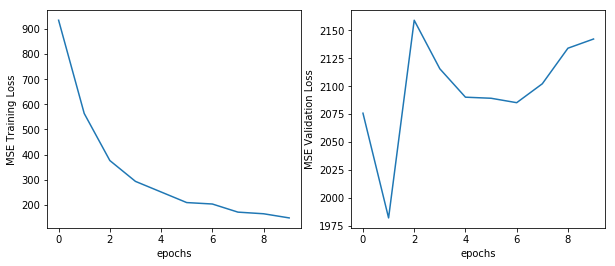

In [35]:
#Plot the results
from matplotlib import pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history1.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot(history1.history['val_loss'])
plt.ylabel('MSE Validation Loss')
plt.xlabel('epochs')
plt.show()

### Visualize First Network

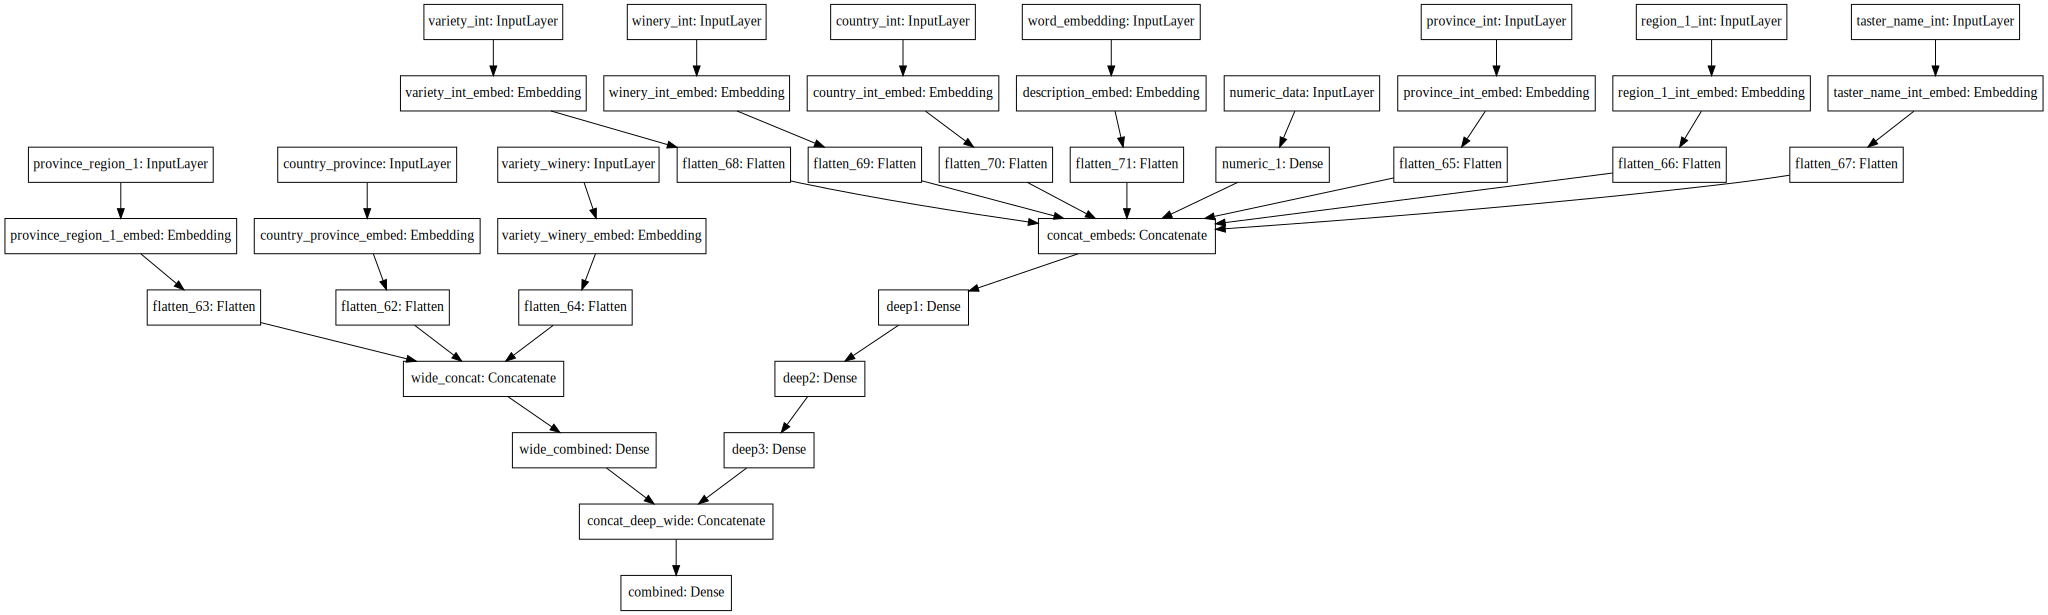

In [36]:
#visualize network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

## Construct Second Neural Network
Our second neural network will omit the text embedding of the description column. We feel that it is possible that choice of words in the description may not be very indicative of the price of the wine, and we would like to test a model excluding this feature. 

In [37]:
# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns1:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='linear',name='wide_combined')(wide_branch)


# reset this input branch
all_deep_branch_outputs = []


# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)


#get a dense branch of the numeric features
all_inputs.append(Input(shape=(1,),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=15, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append(x)



# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='linear',name='combined')(final_branch)

model2 = Model(inputs=all_inputs, outputs=final_branch)


model2.compile(optimizer='adam',
              loss='mean_squared_error')

# Add history to track model
# Note that the inputs must be added in the order they are appended in the
# all_inputs vector,
history2 = model2.fit(X_ints_train + [X_train_num],
                    y_train, 
                    epochs=10,
                    batch_size = 20,
                    verbose=1,
                    validation_data = (X_ints_test + [X_test_num], y_test))


yhat = model2.predict(X_ints_test + [X_test_num]) # each branch has an input
rmse = np.sqrt(mt.mean_squared_error(y_test,yhat))
print('root mean squared error: ', rmse)

Train on 91260 samples, validate on 10140 samples
Epoch 1/10
91260/91260 [==============================] - 84s 922us/step - loss: 904.8207 - val_loss: 2063.0352
Epoch 2/10
91260/91260 [==============================] - 83s 905us/step - loss: 653.6981 - val_loss: 1875.5496
Epoch 3/10
91260/91260 [==============================] - 83s 907us/step - loss: 590.1096 - val_loss: 1838.8994
Epoch 4/10
91260/91260 [==============================] - 83s 910us/step - loss: 566.7157 - val_loss: 1886.1172
Epoch 5/10
91260/91260 [==============================] - 83s 910us/step - loss: 552.1098 - val_loss: 1771.4966
Epoch 6/10
91260/91260 [==============================] - 83s 910us/step - loss: 532.1184 - val_loss: 1731.4977
Epoch 7/10
91260/91260 [==============================] - 83s 909us/step - loss: 512.0628 - val_loss: 1722.3350
Epoch 8/10
91260/91260 [==============================] - 83s 909us/step - loss: 501.9491 - val_loss: 1569.6685
Epoch 9/10
91260/91260 [==============================

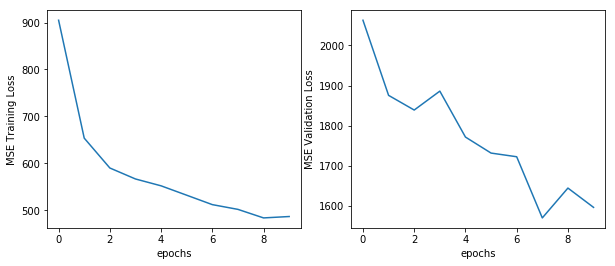

In [41]:
#Plot the results
from matplotlib import pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot(history2.history['val_loss'])
plt.ylabel('MSE Validation Loss')
plt.xlabel('epochs')
plt.show()

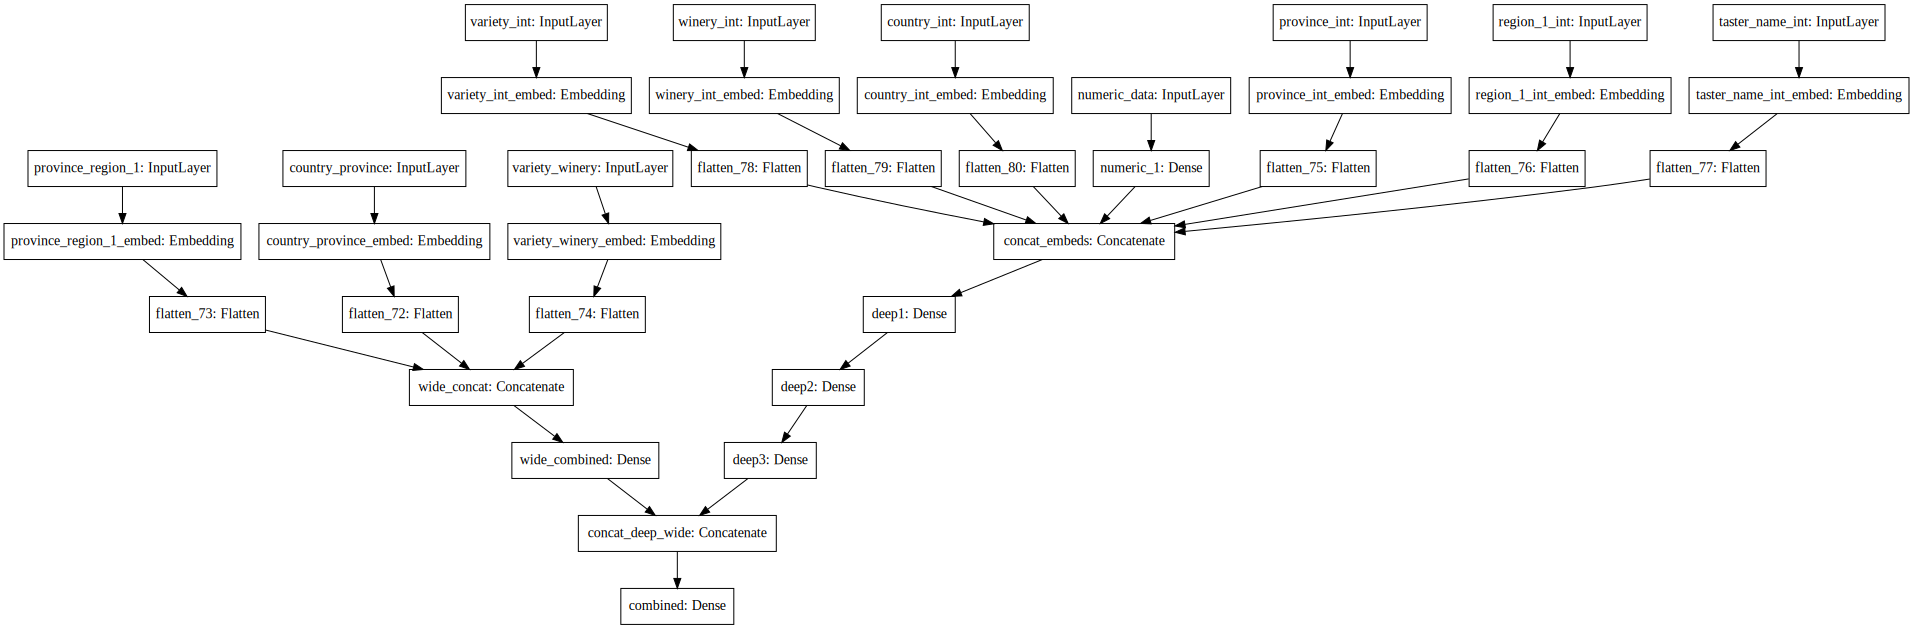

In [42]:
#visualize network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

## Construct Third Neural Network
Finally, we construct a neural network with many crossed columns and the deep embedded text descriptions. 

In [43]:
# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

cross_columns2 = [['country','province'],['province','region_1'],['variety','winery'],
                 ['taster_name','variety'],['taster_name','country'],['country','variety']]

for cols in cross_columns2:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='linear',name='wide_combined')(wide_branch)


# reset this input branch
all_deep_branch_outputs = []


# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)


#We also embed the text data   
# define documents
X_doc_train = df_train['description'].values.tolist()
X_doc_test = df_test['description'].values.tolist()

# integer encode the documents
vocab_size = 5000
X_train_encoded = [one_hot(t, vocab_size, filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ') for t in X_doc_train]
X_test_encoded = [one_hot(t, vocab_size, filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ') for t in X_doc_test]

#Get maximum length of the encoded documents and pad all to this length 
max1 = max([len(i) for i in X_train_encoded])
max2 = max([len(i) for i in X_test_encoded])
max_length = max(max1,max2)

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

# create embedding branch for the words in the description
inputs = Input(shape=(max_length,),dtype='int32', name='word_embedding')
all_inputs.append(inputs)
x = Embedding(input_dim=vocab_size, 
              output_dim=int(np.sqrt(vocab_size)), 
              input_length=max_length, name='description_embed')(inputs)
x = Flatten()(x)
all_deep_branch_outputs.append(x)

  
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(1,),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=15, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append(x)

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='linear',name='combined')(final_branch)

model3 = Model(inputs=all_inputs, outputs=final_branch)


model3.compile(optimizer='adam',
              loss='mean_squared_error')

# Add history to track model
# Note that the inputs must be added in the order they are appended in the
# all_inputs vector,
history3 = model3.fit(X_ints_train + [X_train_padded] + [X_train_num],
                    y_train, 
                    epochs=10,
                    batch_size = 20,
                    verbose=1,
                    validation_data = (X_ints_test + [X_test_padded] + [X_test_num], y_test))


yhat = model3.predict(X_ints_test + [X_test_padded] + [X_test_num]) # each branch has an input
print('root mean squared error: ',np.sqrt(mt.mean_squared_error(y_test,yhat)))

Train on 91260 samples, validate on 10140 samples
Epoch 1/10
91260/91260 [==============================] - 101s 1ms/step - loss: 904.4749 - val_loss: 1971.1486
Epoch 2/10
91260/91260 [==============================] - 99s 1ms/step - loss: 532.9147 - val_loss: 1938.8831
Epoch 3/10
91260/91260 [==============================] - 99s 1ms/step - loss: 351.1958 - val_loss: 2037.3910
Epoch 4/10
91260/91260 [==============================] - 99s 1ms/step - loss: 277.1392 - val_loss: 2098.4606
Epoch 5/10
91260/91260 [==============================] - 99s 1ms/step - loss: 246.3036 - val_loss: 2049.6742
Epoch 6/10
91260/91260 [==============================] - 99s 1ms/step - loss: 217.8676 - val_loss: 2070.8781
Epoch 7/10
91260/91260 [==============================] - 100s 1ms/step - loss: 187.7407 - val_loss: 2067.7855
Epoch 8/10
91260/91260 [==============================] - 99s 1ms/step - loss: 141.8250 - val_loss: 2101.6935
Epoch 9/10
91260/91260 [==============================] - 99s 1ms/st

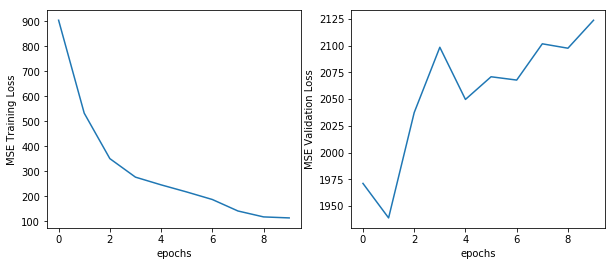

In [44]:
#Plot the results
from matplotlib import pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history3.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot(history3.history['val_loss'])
plt.ylabel('MSE Validation Loss')
plt.xlabel('epochs')
plt.show()

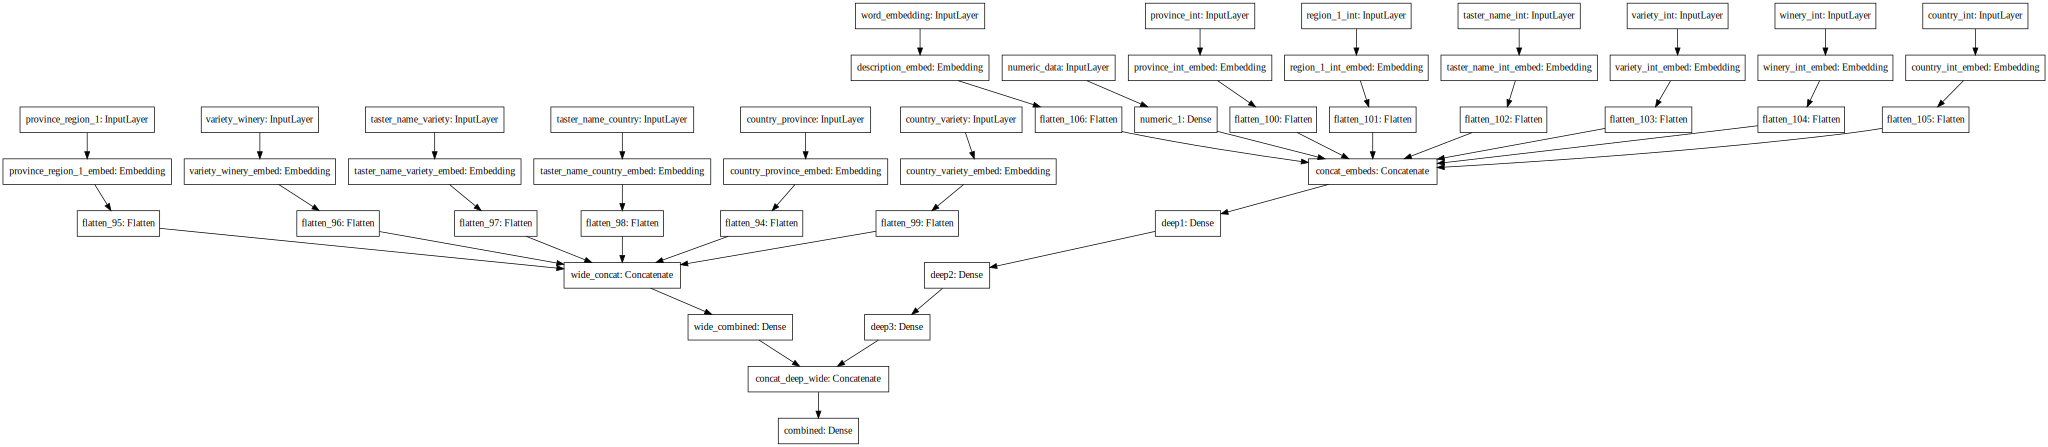

In [45]:
#visualize network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model3).create(prog='dot', format='svg'))

## Cross Validation to Tune Layers
We will now implement our chosen method of cross-validation to find the optimal number of layers for the deep branch. Since the neural network that omitted the text embedding performed the best, we will use this architecture for our final network. We will use 5 fold cross validation as described. Due to time constraints, will train each model for 7 epochs instead of the 10 we used when comparing the different architectures. The final model will be used to predict prices on the test data set, giving us a final estimate of the real-world RMSE. First we cross-validate on original wide and deep network that omitted the embedded text data. 

In [46]:
from sklearn.model_selection import ShuffleSplit

# set shuffler settings 
shuffler = ShuffleSplit(n_splits=5, train_size=.8, test_size=.2)

cross_columns1 = [['country','province'],['province','region_1'],['variety','winery']]

rmse4 = []

for train_index, test_index in shuffler.split(df_train):

    # we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    
    #create new train and test data
    df_train_new = df_train.iloc[train_index]
    df_test_new = df_train.iloc[test_index]
    
    X_train_num_new = df_train_new['points'].values
    X_test_num_new = df_test_new['points'].values
    
    y_train_new = df_train_new['price'].values
    y_test_new = df_test_new['price'].values

    for cols in cross_columns1:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()
    
        # create crossed labels
        X_crossed_train = df_train_new[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test_new[cols].apply(lambda x: '_'.join(x), axis=1)
    
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )
    
        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    
    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='linear',name='wide_combined')(wide_branch)


    # reset this input branch
    all_deep_branch_outputs = []


    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train_new[col].values )
        X_ints_test.append( df_test_new[col].values )
    
        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)


    #get a dense branch of the numeric features
    all_inputs.append(Input(shape=(1,),
                        sparse=False,
                        name='numeric_data'))

    x = Dense(units=15, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append(x)



    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=1,activation='linear',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)


    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    # Add history to track model
    # Note that the inputs must be added in the order they are appended in the
    # all_inputs vector,
    history = model.fit(X_ints_train + [X_train_num_new],
                        y_train_new, 
                        epochs=7,
                        batch_size = 20,
                        verbose=1)


    yhat = model.predict(X_ints_test + [X_test_num_new]) # each branch has an input
    rmse4.append(np.sqrt(mt.mean_squared_error(y_test_new,yhat)))
    
    if len(rmse4)== shuffler.n_splits:
            rmse_mean4 = np.mean(np.array(rmse4))
            rmse_stdev4 = np.std(np.array(rmse4))
            print(rmse4)
            print(rmse_mean4)
            print(rmse_stdev4)

Epoch 1/7
73008/73008 [==============================] - 66s 905us/step - loss: 977.9560
Epoch 2/7
73008/73008 [==============================] - 63s 867us/step - loss: 695.9466
Epoch 3/7
73008/73008 [==============================] - 64s 877us/step - loss: 632.2271
Epoch 4/7
73008/73008 [==============================] - 64s 879us/step - loss: 600.5033
Epoch 5/7
73008/73008 [==============================] - 64s 874us/step - loss: 575.0647
Epoch 6/7
73008/73008 [==============================] - 64s 875us/step - loss: 559.8936
Epoch 7/7
73008/73008 [==============================] - 64s 874us/step - loss: 536.7934
Epoch 1/7
73008/73008 [==============================] - 66s 907us/step - loss: 1032.3073
Epoch 2/7
73008/73008 [==============================] - 64s 878us/step - loss: 745.1818
Epoch 3/7
73008/73008 [==============================] - 64s 877us/step - loss: 664.7041
Epoch 4/7
73008/73008 [==============================] - 64s 878us/step - loss: 620.6488
Epoch 5/7
73008/7300

## Try 4 Layers
We increase the number of layers in the deep branch to 4. 

In [47]:
from sklearn.model_selection import ShuffleSplit

# set shuffler settings 
shuffler = ShuffleSplit(n_splits=5, train_size=.8, test_size=.2)

cross_columns1 = [['country','province'],['province','region_1'],['variety','winery']]

rmse5 = []

for train_index, test_index in shuffler.split(df_train):

    # we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    
    #create new train and test data
    df_train_new = df_train.iloc[train_index]
    df_test_new = df_train.iloc[test_index]
    
    X_train_num_new = df_train_new['points'].values
    X_test_num_new = df_test_new['points'].values
    
    y_train_new = df_train_new['price'].values
    y_test_new = df_test_new['price'].values

    for cols in cross_columns1:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()
    
        # create crossed labels
        X_crossed_train = df_train_new[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test_new[cols].apply(lambda x: '_'.join(x), axis=1)
    
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )
    
        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    
    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='linear',name='wide_combined')(wide_branch)


    # reset this input branch
    all_deep_branch_outputs = []


    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train_new[col].values )
        X_ints_test.append( df_test_new[col].values )
    
        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)


    #get a dense branch of the numeric features
    all_inputs.append(Input(shape=(1,),
                        sparse=False,
                        name='numeric_data'))

    x = Dense(units=15, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append(x)



    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=75,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep4')(deep_branch)
    
    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=1,activation='linear',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)


    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    # Add history to track model
    # Note that the inputs must be added in the order they are appended in the
    # all_inputs vector,
    history = model.fit(X_ints_train + [X_train_num_new],
                        y_train_new, 
                        epochs=7,
                        batch_size = 20,
                        verbose=1)


    yhat = model.predict(X_ints_test + [X_test_num_new]) # each branch has an input
    rmse5.append(np.sqrt(mt.mean_squared_error(y_test_new,yhat)))
    
    if len(rmse5)== shuffler.n_splits:
            rmse_mean5 = np.mean(np.array(rmse5))
            rmse_stdev5 = np.std(np.array(rmse5))
            print(rmse5)
            print(rmse_mean5)
            print(rmse_stdev5)

Epoch 1/7
73008/73008 [==============================] - 70s 956us/step - loss: 978.8583
Epoch 2/7
73008/73008 [==============================] - 67s 914us/step - loss: 727.7325
Epoch 3/7
73008/73008 [==============================] - 67s 918us/step - loss: 666.2351
Epoch 4/7
73008/73008 [==============================] - 68s 925us/step - loss: 605.3233
Epoch 5/7
73008/73008 [==============================] - 67s 913us/step - loss: 592.9954
Epoch 6/7
73008/73008 [==============================] - 67s 915us/step - loss: 554.9210
Epoch 7/7
73008/73008 [==============================] - 66s 905us/step - loss: 548.9162
Epoch 1/7
73008/73008 [==============================] - 69s 940us/step - loss: 982.6726
Epoch 2/7
73008/73008 [==============================] - 67s 925us/step - loss: 721.7965
Epoch 3/7
73008/73008 [==============================] - 67s 923us/step - loss: 649.3922
Epoch 4/7
73008/73008 [==============================] - 68s 926us/step - loss: 626.5748
Epoch 5/7
73008/73008

## Try 2 Layers
Finally, we try 2 layers in the deep branch. 

In [49]:
# set shuffler settings 
shuffler = ShuffleSplit(n_splits=5, train_size=.8, test_size=.2)

cross_columns1 = [['country','province'],['province','region_1'],['variety','winery']]

rmse6 = []

for train_index, test_index in shuffler.split(df_train):

    # we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []
    
    #create new train and test data
    df_train_new = df_train.iloc[train_index]
    df_test_new = df_train.iloc[test_index]
    
    X_train_num_new = df_train_new['points'].values
    X_test_num_new = df_test_new['points'].values
    
    y_train_new = df_train_new['price'].values
    y_test_new = df_test_new['price'].values

    for cols in cross_columns1:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()
    
        # create crossed labels
        X_crossed_train = df_train_new[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test_new[cols].apply(lambda x: '_'.join(x), axis=1)
    
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )
    
        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    
    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='linear',name='wide_combined')(wide_branch)


    # reset this input branch
    all_deep_branch_outputs = []


    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train_new[col].values )
        X_ints_test.append( df_test_new[col].values )
    
        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)


    #get a dense branch of the numeric features
    all_inputs.append(Input(shape=(1,),
                        sparse=False,
                        name='numeric_data'))

    x = Dense(units=15, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append(x)



    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=25,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep2')(deep_branch)
    
    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=1,activation='linear',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)


    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    # Add history to track model
    # Note that the inputs must be added in the order they are appended in the
    # all_inputs vector,
    history = model.fit(X_ints_train + [X_train_num_new],
                        y_train_new, 
                        epochs=7,
                        batch_size = 20,
                        verbose=1)


    yhat = model.predict(X_ints_test + [X_test_num_new]) # each branch has an input
    rmse6.append(np.sqrt(mt.mean_squared_error(y_test_new,yhat)))
    
    if len(rmse6)== shuffler.n_splits:
            rmse_mean6 = np.mean(np.array(rmse6))
            rmse_stdev6 = np.std(np.array(rmse6))
            print(rmse6)
            print(rmse_mean6)
            print(rmse_stdev6)

Epoch 1/7
73008/73008 [==============================] - 70s 953us/step - loss: 1135.6552
Epoch 2/7
73008/73008 [==============================] - 66s 910us/step - loss: 862.7768
Epoch 3/7
73008/73008 [==============================] - 66s 911us/step - loss: 751.1728
Epoch 4/7
73008/73008 [==============================] - 67s 911us/step - loss: 688.5073
Epoch 5/7
73008/73008 [==============================] - 67s 912us/step - loss: 649.8213
Epoch 6/7
73008/73008 [==============================] - 67s 913us/step - loss: 620.1584
Epoch 7/7
73008/73008 [==============================] - 67s 913us/step - loss: 598.2590
Epoch 1/7
73008/73008 [==============================] - 70s 954us/step - loss: 977.9285
Epoch 2/7
73008/73008 [==============================] - 67s 915us/step - loss: 663.4969
Epoch 3/7
73008/73008 [==============================] - 67s 917us/step - loss: 552.0021
Epoch 4/7
73008/73008 [==============================] - 67s 919us/step - loss: 511.1520
Epoch 5/7
73008/7300

## Final Estimate of RMSE
Since the average RMSE is slightly lower for the wide and deep network with 3 layers than it is for the network with 2 layers, we will use a 3 layer wide and deep network without text embedding. We will caculated the test RMSE on the 10% of the data that we withhheld as a test set when we constructed the models above. Therefore, our final estimate of the test RMSE is 39.95. This is likely not acceptable for the conditions that we laid out in the business understanding section. Perhaps more data relating to the factors that set the prices of these wines is needed, or a wide and deep neural network is simply not the best approach for this problem. 

## Compare to MLP
We will compare the wide and deep network with the best cross-validation performance to a multi-layer perceptron built in keras using Bland-Altman plots. The results are discussed below. 

In [56]:
# set shuffler settings 
shuffler = ShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8)
rmse_mlp=[]

In [57]:
df_train_array = df_train.values

for train_index, test_index in shuffler.split(df_train_array):
    df_train, df_test = pd.DataFrame(df_train_array[train_index],columns=df_train.columns),   pd.DataFrame(df_train_array[test_index],columns=df_train.columns)
    # we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []



    #Make response vector
    y_train = df_train['price'].values
    y_test = df_test['price'].values

    #Get numeric variables as well
    X_train_num = df_train['points'].values
    X_test_num = df_test['points'].values

    # reset this input branch
    all_deep_branch_outputs = []


    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)
    #We also embed the text data   
    # define documents
    X_doc_train = df_train['description'].values.tolist()
    X_doc_test = df_test['description'].values.tolist()

    # integer encode the documents
    vocab_size = 5000
    X_train_encoded = [one_hot(t, vocab_size) for t in X_doc_train]
    X_test_encoded = [one_hot(t, vocab_size) for t in X_doc_test]

    #Get maximum length of the encoded documents and pad all to this length 
    max1 = max([len(i) for i in X_train_encoded])
    max2 = max([len(i) for i in X_test_encoded])
    max_length = max(max1,max2)

    X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')
    X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

    # create embedding branch for the words in the description
    inputs = Input(shape=(max_length,),dtype='int32', name='word_embedding')
    all_inputs.append(inputs)
    x = Embedding(input_dim=vocab_size, 
                  output_dim=int(np.sqrt(vocab_size)), 
                  input_length=max_length, name='description_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)


    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(1,),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=15, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append(x)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=30,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=30,activation='relu', name='deep3')(deep_branch)
    final_branch = Dense(units=1,activation='linear',name='final')(deep_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)


    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    # Add history to track model
    history = model.fit(X_ints_train + [X_train_padded] + [X_train_num],
                        y_train, 
                        epochs=7,
                        batch_size = 20,
                        verbose=1)
    
    yhat = model.predict(X_ints_test + [X_test_padded] + [X_test_num]) # each branch has an input
    rmse_mlp.append(np.sqrt(mt.mean_squared_error(y_test,yhat)))
    
    if len(rmse_mlp)== shuffler.n_splits:
            rmse_mean_mlp = np.mean(np.array(rmse_mlp))
            rmse_std_mlp = np.std(np.array(rmse_mlp))
            print(rmse_mlp)
            print(rmse_mean_mlp)
            print(rmse_std_mlp)

Epoch 1/7
37379/37379 [==============================] - 27s 713us/step - loss: 897.8330
Epoch 2/7
37379/37379 [==============================] - 23s 602us/step - loss: 508.4814
Epoch 3/7
37379/37379 [==============================] - 23s 605us/step - loss: 258.2343
Epoch 4/7
37379/37379 [==============================] - 22s 600us/step - loss: 167.9510
Epoch 5/7
37379/37379 [==============================] - 23s 602us/step - loss: 130.4641
Epoch 6/7
37379/37379 [==============================] - 22s 602us/step - loss: 94.8631
Epoch 7/7
37379/37379 [==============================] - 23s 608us/step - loss: 81.6624
Epoch 1/7
37379/37379 [==============================] - 27s 722us/step - loss: 1207.4420
Epoch 2/7
37379/37379 [==============================] - 23s 618us/step - loss: 794.9486
Epoch 3/7
37379/37379 [==============================] - 23s 616us/step - loss: 565.4601
Epoch 4/7
37379/37379 [==============================] - 23s 616us/step - loss: 464.3335
Epoch 5/7
37379/37379 

Exceptional Work (10 points total)
* 5000 students: You have free reign to provide additional analyses.

* One idea (required for 7000 level students): Capture the embedding weights from the deep network and (if needed) perform t-SNE clustering on the output of these embedding layers. That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

### Bland-Altman Plot

Bland Altman Plots compare two quantatative measurements and determine the extent of agreement.  If the mean of the difference of the observations differs from 0, that indicates a bias.  The bias may be fixed (constant difference) or variable.  It is expected that 95% of the points will fall within 2 standard deviations of the mean, if the differences are normally distributed.  We should decide a priori what an acceptable limit is to call the distributions congruent.

This plot would seem to indicate that there is significant disagreement between our wide and deep network and the MLP. The wide and deep neural network appears to be a much better predictor than the MLP, as the mean difference between the two is -10. However, the 95% confidence interval for the difference in the two measurements also includes 0, and so not much can really be said about the difference between the estimates. 

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# input numpy arrays/lists for two different sets of data to produce plot 
def plot_bland_altman(input1, input2):
    mean = np.mean([input1, input2], axis=0)
    diff = input2 - input1
    mean_diff = np.mean(diff)
    stdev = np.std(diff)

    plt.scatter(mean, diff)
    plt.axhline(mean_diff, color='black')
    plt.axhline(mean_diff + 1.96*stdev, color='red')
    plt.axhline(mean_diff - 1.96*stdev, color='red')
    plt.xlabel('Mean')
    plt.ylabel('Mean Difference')
    plt.title('Bland-Altman Plot')
    plt.show()

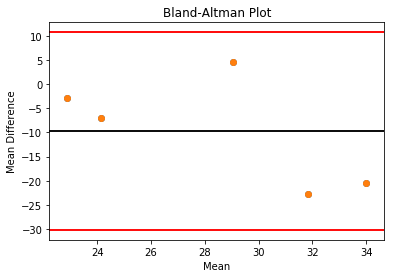

In [61]:
plot_bland_altman(np.asarray(rmse_mlp), np.asarray(rmse4))

## Embedded Weight Visualization

t-SNE is a dimensionality reduction method that focuses on preserving local similarities. We selected the top 20 based the frequency within our dataset to reduce the amount of clutter when plotting. We will examine these plots for similarities in the various categorical variables in the data set and hypothesize about what might be causing this clustering.

In [70]:
# plots 2d or t-SNE depending on dimensionality
# requires layer name match format of encoder
from sklearn.manifold import TSNE
import seaborn as sns

def plot_weights(model, layer_names, encoders, df):
    weight_dict = {}    
    for layer_name in layer_names:
        weight_dict[layer_name] = model.get_layer(layer_name).get_weights()
    
    def layer_to_category(layer_name): ## assumes the same naming convention as larson's notes
        return layer_name[:-10]
    
    for layer_name in layer_names:
        # if 2 d, just plot
        if weight_dict[layer_name][0].shape[1] == 2:
            weight_df = pd.DataFrame(weight_dict[layer_name][0])
            weight_df.columns = ['w1', 'w2']
            # assuming 
            weight_df['name'] = encoders[layer_to_category(layer_name)].classes_

            g = sns.lmplot('w1', 'w2', weight_df, fit_reg=False)
            texts = [plt.text(weight_df.w1[i], weight_df.w2[i], weight_df.name[i]) for i in range(len(weight_df))]
            plt.title('Weights for ' + layer_to_category(layer_name))
            plt.show()
        else:
            name = layer_to_category(layer_name)
            if len(df[name].unique()) > 20: # only look at the top 20 for categories
                categories = df[name].value_counts().head(n=20).index
                weights_embedded = TSNE(n_components=2).fit_transform(weight_dict[layer_name][0])
                weight_df = pd.DataFrame(weights_embedded)
                weight_df.columns = ['w1', 'w2']
                # assuming 
                weight_df['name'] = encoders[name].classes_
                weight_df = weight_df.loc[weight_df['name'].isin(categories)].reset_index(drop = True) 
                # filter for top 20 categories and reseting index 
                
            else:
                weights_embedded = TSNE(n_components=2).fit_transform(weight_dict[layer_name][0])
                weight_df = pd.DataFrame(weights_embedded)
                weight_df.columns = ['w1', 'w2']
                # assuming 
                weight_df['name'] = encoders[name].classes_

            g = sns.lmplot('w1', 'w2', weight_df, fit_reg=False)
            texts = [plt.text(weight_df.w1[i], weight_df.w2[i], weight_df.name[i]) for i in range(len(weight_df))]
            plt.title('Weights for ' + layer_to_category(layer_name))


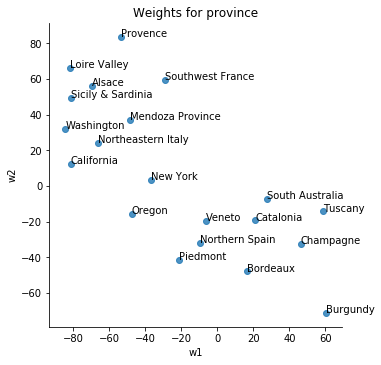

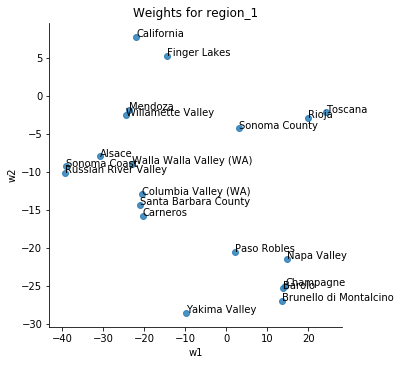

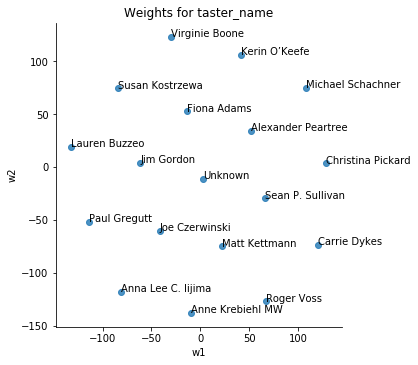

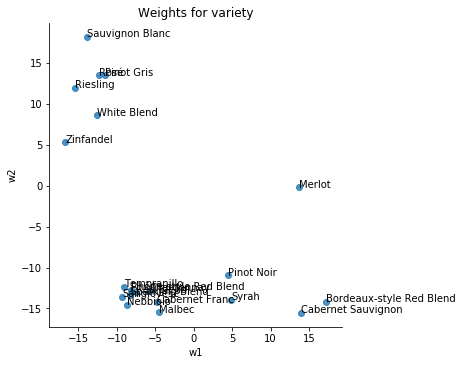

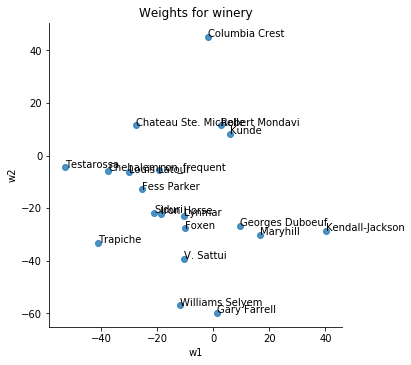

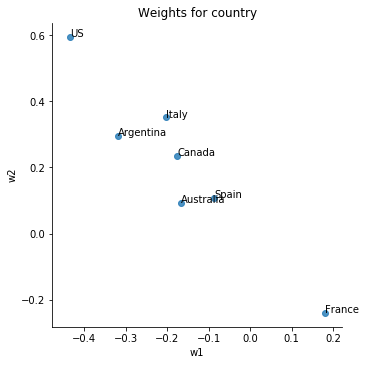

In [71]:
# embedded layer names
layer_names = ['province_int_embed','region_1_int_embed','taster_name_int_embed', 'variety_int_embed','winery_int_embed',
              'country_int_embed']

plot_weights(model2, layer_names, encoders, df) # need original dataframe in order to filter out top 20 categories


Based on the plot of weights for Country, it appears that the United States and France are much different than the other nations. France has one of the greatest winemaking traditions in the world, and so it may not be surprising that French wines stand out from those made in other countries. The United States, by comparison, has a very new winemaking tradition, and may not be able to compete with European wines. This, however, would not explain the difference between Canada and the US.  

Provinces appear to be clustered based on the similarity of their climates. For example, South Australia, Tuscany, and Catalonia all have Mediterranean climates. Likewise, Oregon, California, Washington, and New York all have (relatively) similar climates. The same can be said for region_1 and winery. Subareas and wineries that are in the same province or country and generally grouped together.

There does not appear to be a strong clustering effect for taster_name. Perhaps each of these tasters reviews a wide range of wines, with many differences in price. 

The varieties of the grapes used in wine production appear to cluster based on whether they are red or white. This is expected, as white wines are typically cheaper than white wines, as white wines generally do not require aging, eliminating the added expenses that the aging process incurs. 